# N-Body Project
## By: Christian Ivanov 260808189

For the following N-body simulation, I will be employing the particle mesh method. This method uses the fact that the gravitational potential from any configuration of charge obeys Poisson's equation: $$ \nabla ^2 V = 4 \pi G \rho$$ 

And thus, from the properties of Poisson's equation, we have

$$ V = G_{\nabla ^2} \otimes \rho$$

where $G_{\nabla ^2}$ is the Green's function for the Laplacian in 3D. In other words, it is the impulse-response of the 3D laplacian, and so it obeys

$$ \nabla ^2 G_{\nabla ^2} = \delta $$

But notice that this corresponds to the charge density of a single particle of unit mass at the origin, and so we must have

$$ V_{particle} = G_{\nabla ^2} = \frac{4 \pi G}{r}$$

Once we have used the above to find the potential for a given charge distribution, we evolve it by computing the forces applied on it. These are given by:

$$ F = - m \nabla V$$

For each particle, and so we can find it by taking the gradient of the potential at each step.



The particle-mesh method consists of distributing the mass of the particles based on their positions to a discretised grid to which we then apply the above equations (using fourrier transforms to compute the convolution) to find the forces on the particles at each step, and thus evolve their position and velocity over time. So while the potential and forces are discretised onto a coarse grid, the particles' individual positions, velocities and masses are not.


Note that while the equations derived above only apply in 3D, it is very computetionally expensive to run this algorithm for many particles on a large 3D grid and the results are difficult to plot. Thus, for the remainder of the assignment, I will be working on a 2D slice of 3D space, where the particles are confined to a plane. Such a configuration would in principle generate no forces which would push the particles out of the plane, and so it does physically make sence.

In [1746]:
import numpy as np
import time
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import clear_output
from IPython.display import Video

I will start by writing a function which generates the previously mentionned Green's function for the laplacian in 3D for a square box of size length $n$. I will do this by arranging numbers from $0$ to $n/2 + 1$ rounded down, concatanating the array to its inverse with the zero term removed and copying it $n$ times to form a grid of x cordinates centered roughly in the middle of the grid, which I then transpose to get the y coordinates. This gives us the absolute value of the x and y coordinates in the box centered in the middle of the box (or rather in the grid cell right next to to the middle).

Note that this only works for boxes where $n$ is an even number, but since the FFTs which we will use later work fastest when $n$ is a power of 2, and that we have no reason a-proiri to pick an odd-number sized box, I will only run the simlation on boxes whose sides are powers of two.

So, I then use the coordinate grids to calculate the green's function at each point on the grid, adding a softening factor $\epsilon$ which prevents it from blowing up to infinity in the middle. This has the effect of reducing the forces at short-ranges, allowing particles to get closer together without flinging each-other out to infinity due to the diverging forces.

$$ G_{\nabla ^2} = \frac{4 \pi G}{r} \approx \frac{4 \pi G}{\sqrt{x^2 + y^2 + \epsilon}}$$

Since we will be convolving the Green's function with the charge density, the routine outputs its FFT to later speed things up.

Note that with how I've modeled it, $\sqrt{\epsilon}$ represents the closest distance the particles can get before the attractive forces between them stop increasing. Since our grid cells have size 1, then we our model stops accurately represnting forces for particles less than a distance of 1 apart, and so for most of the simulations, I wil pick an $\epsilon = 0.5$ which gives us a maximal effective separation between the particles of slightly less than one.

In [2059]:
def Green_func_fourrier(n,G,soft):
    a1 = np.arange(n//2+1)
    a2 = a1[::-1][:-1]
    a = np.concatenate((a2,a1[:-1]))
    x = np.array([a]*n)
    y = np.transpose(x)
    Green_func = G/(4*np.pi*np.sqrt((x**2+y**2+soft)))
    return np.fft.rfft2(Green_func)

I will now set up a routine which advances the system by one step in the case of periodic boundary conditions.

It will take the size of the box, the number of particles, the vector positions and velocities of all the particles, their masses, the fourrier transform of the Green's function and the timestep as inputs.

First, we need a mass-assignment function, which converts the positions and masses of the particles into a density grid. The simplest and fastest method is the "Nearest Grid Point", which amounts to placing the masses into a 2D histogram. I will be using this method.

Using FFTs to convolve the density grid with our Green's function, we get the potential

$$ V = G_{\nabla ^2} \otimes \rho = \mathscr{F}^{-1} \left( \mathscr{F}(\rho) \mathscr{F}(G_{\nabla ^2}) \right) $$

and then take the gradient of the potential to get the forces as previously mentionned $ F = - m \nabla V $

Then, we evlove the velocity by applying the backwards Euler method to each particle: we first evolve the velocities by assigning a force on each particle based on its position on the grid (I do this by rounding its position down to an integer and using that as an index on the force grid, which works since python indices start from zero)

$$v_{new} = v_{old} + dt \frac{F}{m}$$

after which we evolve the positions by applying 

$$ x_{new} = x_{old} + dt v_{new}$$

We could have used $v_{old}$ when evolving the positions too, which would be the regular Euler's method, but in this case, backwards Euler is a bit simpler to code and appears to give better results after some testing, so I will use it.

The FFT automatically applies periodic boundary conditions for the potential, but to do the same for the particle positions, I instead take the position modulo $n$ (the size of thet box) at each time step over both axes, which makes sure the particles obey periodc boundary conditions. 

The routine then returns the new positions and velocities to be used for the next step, as well as the potential, density grid, and total system energy, which I will use to make plots and to verify if energy is conseved.

In [2060]:
def take_step_periodic(n,npart,pos,vel,m,Gk,dt):
    rho=np.histogram2d(pos[0]%n,pos[1]%n,bins=n,range=[[0, n], [0, n]],weights=m)[0]
    pot = np.fft.fftshift(np.fft.irfft2(np.fft.rfft2(rho)*Gk))
    F = np.gradient(pot)
    pos = pos%n
    vel[0]=vel[0]+dt*F[0][pos[0].astype(int),pos[1].astype(int)]/m
    vel[1]=vel[1]+dt*F[1][pos[0].astype(int),pos[1].astype(int)]/m
    pos=(pos+(vel*dt))%n
    E = np.sum(0.5*(m*(vel[0]**2+vel[1]**2))-0.5*np.sum(pot))
    return pot,rho,pos,vel,E

I also tried implementing the Improved Euler's method and a variation of the Leapfrog method to get more accurate results at the expense of computation time, as shown below.

Improved Euler takes a trial step using regular Euler's method and then computes the force at the next position, then taking the average between the two forces to evolve to the next step.

The Leapfrog method does the same thing as Improved Euler but instead evolves the position by assuming the force remains constant between two timesteps and then integrating the position over time with the averaged acceleration obtained from averaging the forces.

I performed numerous tests and found no significant benefit from either of them as opposed to backwards Euler. Both of them are noticeably slower to run and appear to be more sensitive to changes in $\epsilon$ but other than that, they give the same results. I will thus use backwards Euler for the simulations.

In [1980]:
def take_step_periodic_better(n,npart,pos,vel,m,Gk,dt):
    rho=np.histogram2d(pos[0]%n,pos[1]%n,bins=n,range=[[0, n], [0, n]],weights=m)[0]
    pot = np.fft.fftshift(np.fft.irfft2(np.fft.rfft2(rho)*Gk))
    F = np.gradient(pot)
    
    pos_trial = (pos+(vel*dt))%n
    
    rho_trial = np.histogram2d(pos_trial[0]%n,pos_trial[1]%n,bins=n,range=[[0, n], [0, n]],weights=m)[0]
    pot_trial = np.fft.fftshift(np.fft.irfft2(np.fft.rfft2(rho_trial)*Gk))
    F_trial = np.gradient(pot_trial)
    
    F_avg = F+F_trial

    vel[0]=vel[0]+dt*0.5*F_avg[0][pos[0].astype(int),pos[1].astype(int)]/m
    vel[1]=vel[1]+dt*0.5*F_avg[1][pos[0].astype(int),pos[1].astype(int)]/m
    
    pos = (pos+(vel*dt))%n

    E = np.sum(0.5*(m*(vel[0]**2+vel[1]**2))-0.5*np.sum(pot))
    return pot,rho,pos,vel,E

In [1981]:
def take_step_periodic_leapfrog(n,npart,pos,vel,m,Gk,dt):
    rho=np.histogram2d(pos[0]%n,pos[1]%n,bins=n,range=[[0, n], [0, n]],weights=m)[0]
    pot = np.fft.fftshift(np.fft.irfft2(np.fft.rfft2(rho)*Gk))
    F = np.gradient(pot)
    
    pos_old = pos.copy()
    
    pos_trial = np.zeros((2,npart))
    pos_trial[0] = (pos[0]+vel[0]*dt+0.5*(dt**2)*F[0][pos[0].astype(int),pos[1].astype(int)]/m)%n
    pos_trial[1] = (pos[1]+vel[1]*dt+0.5*(dt**2)*F[1][pos[0].astype(int),pos[1].astype(int)]/m)%n
    
    rho_trial = np.histogram2d(pos_trial[0]%n,pos_trial[1]%n,bins=n,range=[[0, n], [0, n]],weights=m)[0]
    pot_trial = np.fft.fftshift(np.fft.irfft2(np.fft.rfft2(rho_trial)*Gk))
    F_trial = np.gradient(pot_trial)
    F_avg = F+F_trial
    
    pos[0] = (pos[0]+vel[0]*dt+0.25*(dt**2)*F_avg[0][pos[0].astype(int),pos[1].astype(int)]/m)%n
    pos[1] = (pos[1]+vel[1]*dt+0.25*(dt**2)*F_avg[1][pos[0].astype(int),pos[1].astype(int)]/m)%n
    
    vel[0]=vel[0]+dt*0.5*F_avg[0][pos_old[0].astype(int),pos_old[1].astype(int)]/m
    vel[1]=vel[1]+dt*0.5*F_avg[1][pos_old[0].astype(int),pos_old[1].astype(int)]/m
    
    E = np.sum(0.5*(m*(vel[0]**2+vel[1]**2))-0.5*np.sum(pot))
    return pot,rho,pos,vel,E

To modify the previous routine to work for finite boundary conditions, I instead perform the potential calculation on a grid 4 times larger (2 times longer edge) by surrounding the original grid with empty space (which I do by making the histogram bigger). Note that this implies the Green's function also has to be for the larger grid.

This has the effect of significantly damping the potential near the edges and preventing it from "leaking" from one side to the other as if the boundary conditions were periodic, and it avoids using a window, which would alter potential near the edges of the box. I then delete the empty areas surrounding the potential and mass distribtion grids to perform the rest of the calculations using backwards Euler as before.

After evolving the positions, I then loop over all the particles and delete any particles which have exited the grid by removing them from the position, velicity and mass arrays. This proved surprisingly tricky to code and the way I did it is rather slow, especially if lots of particles exit the grid during a single timestep. I'm sure there's a better way to do it but this works for now.

The routine then returns back the same data as in the periodic case, with the edition of the mass array, which will have changed if particles exited the grod and were delted.

In [2006]:
def take_step_bounded(n,npart,pos,vel,m,Gk,dt):
    rho=np.histogram2d(pos[0],pos[1],bins=2*n,range=[[-n/2, 1.5*n], [-n/2, 1.5*n]],weights=m)[0]
    pot = np.fft.fftshift(np.fft.irfft2(np.fft.rfft2(rho)*Gk))
    
    pot = np.delete(pot,np.concatenate((np.arange(n//2),np.arange(np.int(1.5*n),np.int(2*n)))),0)
    pot = np.delete(pot,np.concatenate((np.arange(n//2),np.arange(np.int(1.5*n),np.int(2*n)))),1)
    rho = np.delete(rho,np.concatenate((np.arange(n//2),np.arange(np.int(1.5*n),np.int(2*n)))),0)
    rho = np.delete(rho,np.concatenate((np.arange(n//2),np.arange(np.int(1.5*n),np.int(2*n)))),1)
    
    F = np.gradient(pot)
    vel[0]=vel[0]+dt*F[0][pos[0].astype(int),pos[1].astype(int)]/m
    vel[1]=vel[1]+dt*F[1][pos[0].astype(int),pos[1].astype(int)]/m
    pos=pos+(vel*dt)
    i = 0
    while i < npart:
        if max(pos.transpose()[i]) > n:
            pos = np.delete(pos,i,1)
            vel = np.delete(vel,i,1)
            m = np.delete(m,i)
            npart -= 1
            i-=1
        elif min(pos.transpose()[i]) < 0:
            pos = np.delete(pos,i,1)
            vel = np.delete(vel,i,1)
            m = np.delete(m,i)
            npart -= 1
            i-=1
        i+=1
    E = np.sum(0.5*(m*(vel[0]**2+vel[1]**2))-0.5*np.sum(pot))
    return pot,rho,pos,vel,E,npart,m

# Part 1

I will now run the periodic boundary conditions code for a single particle with zero velocity at the center of a grid of size 256. Using G = 1 and a timestep of 0.1, I will plot the position of the particle during 100 steps and animate the potential.

In [1707]:
n = 256
npart = 1
dt = 0.1

m = np.ones(npart)
pos = np.array([[n/2],[n/2]])
vel = np.array([[0.0],[0.0]])


softening = 0.5
G = 1
Gk = Green_func_fourrier(n,G,softening)

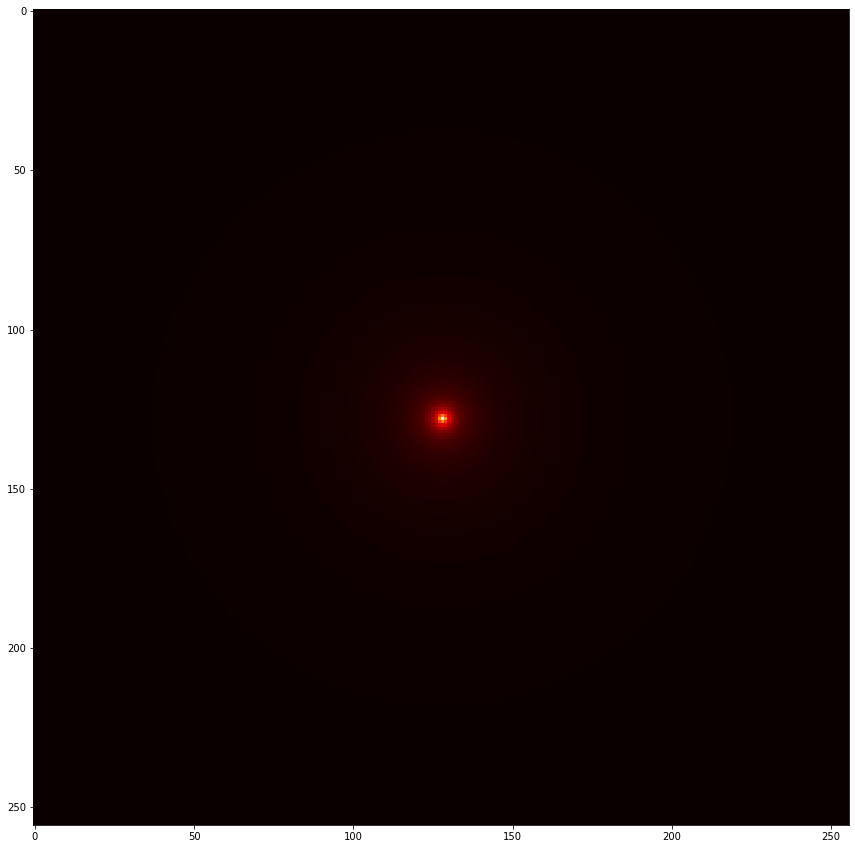

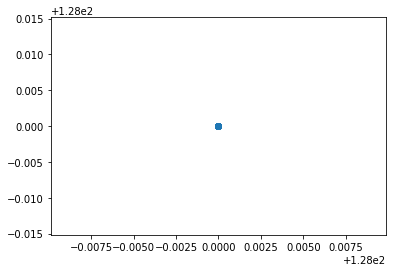

In [1708]:
nruns = 100
px=[]
py=[]
for j in range(runs):
    
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    px.append(pos[0])
    py.append(pos[1])
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(pot,cmap = plt.cm.hot)
    plt.show()
    plt.pause(0.0001)
plt.scatter(px,py)
plt.show()

As we can see, the particle's position does not change at all, just as we would expect.

# Part 2

Using periodic boundary conditions again, I will now place two particles on the central axis of a a 256-sized box and give them opposing initial velocities, adjusting the value of G until so that we get a stable binary orbit.

I will animate the potential over time, and plot their positions throughout the run.

In [1982]:
n = 256
npart = 2
dt = 0.1

m = np.ones(npart)
pos = np.array([[n/2,n/2],[7*n/16,9*n/16]])
vel = np.array([[7,-7],[0.0,0.0]])

softening = 0.5
G = 40000
Gk = Green_func_fourrier(n,G,softening)

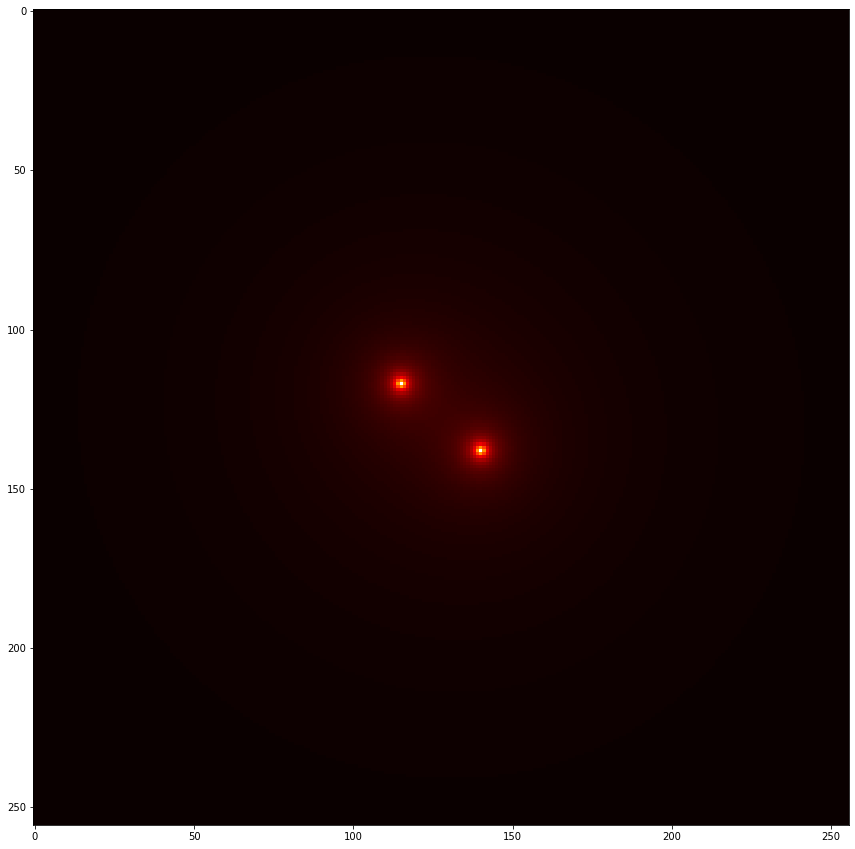

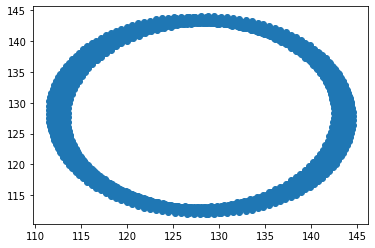

In [1976]:
nruns = 1000
px=[]
py=[]
for j in range(nruns):
    
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    px.append(pos[0])
    py.append(pos[1])
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(pot,cmap = plt.cm.hot)
    plt.show()
    plt.pause(0.0001)
plt.scatter(px,py)
plt.show()

As we can see, after numerous periods, they seem to follow a stable elliptical binary orbit, as they should.

I will animate it into a video to make it easier to watch. For some reason these videos take a very significant amount of time to render (multiple hours), no matter how fast the code runs, so I will upload the final result.

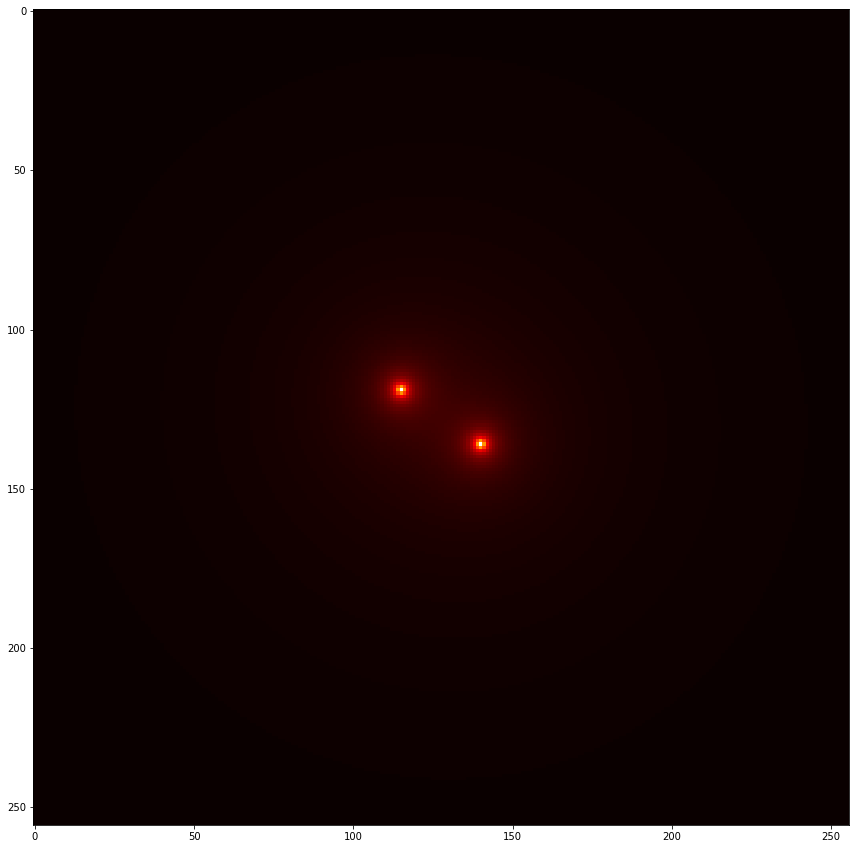

In [1983]:
def new_frame(self):
    global n, npart, pos, vel, m, Gk, dt
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    plt.imshow(pot,cmap = plt.cm.hot)
    
fig = plt.figure(figsize=[15,15])
ani = animation.FuncAnimation(fig,new_frame,frames=1000,interval=16.7)
ani.save('Binary_Pair.mp4')

In [2021]:
Video("Binary_Pair.mp4")

# Part 3
## Periodic

Now to put the code through its paces, I will run the periodic boundary condition code on about a million ($2^{20}$) particles scattered randomly throughout a box of size 1024 starting out at rest, and animate the density grid over time. I will also plot the energy over time to see if it is conserved.

In [2011]:
n = 1024
npart = n**2
dt = 1
m = np.ones(npart)
pos = n*np.random.rand(2,npart)
vel = np.zeros((2,npart))
softening = 0.5
G = 1
Gk = Green_func_fourrier(n,G,softening)

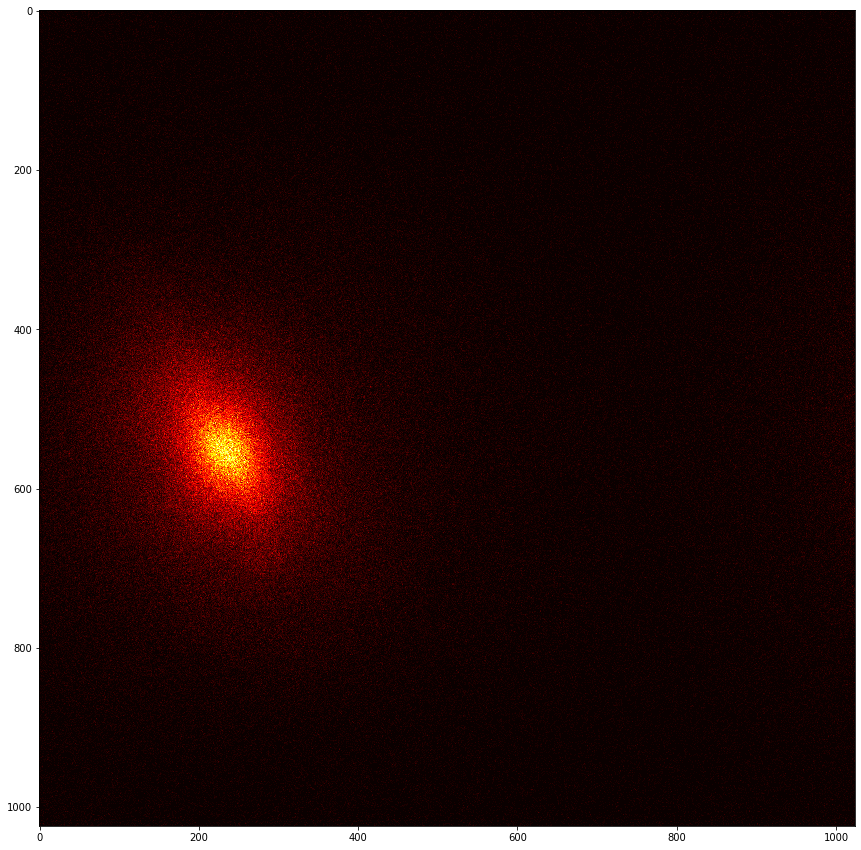

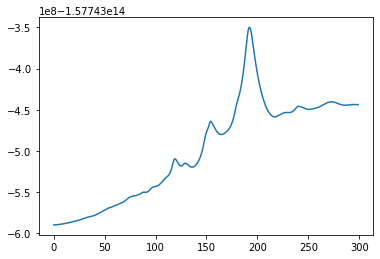

In [2012]:
nruns = 300
E=[]
for j in range(nruns):
    
    pot,rho,pos,vel,Ei = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    E.append(Ei)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,40)
    plt.show()
    plt.pause(0.0001)
plt.plot(E)
plt.show()

Absolutely beautiful!

The particles clump together into larger and larger galaxy-looking blobs until they finally merge into one large blob.

The Energy is also conserved througout the run to a factor of $10^7$ out of $10^{14}$, and thus to an accuracy of $10^{-7}$ which is excelent!!

I will now make it into a video:

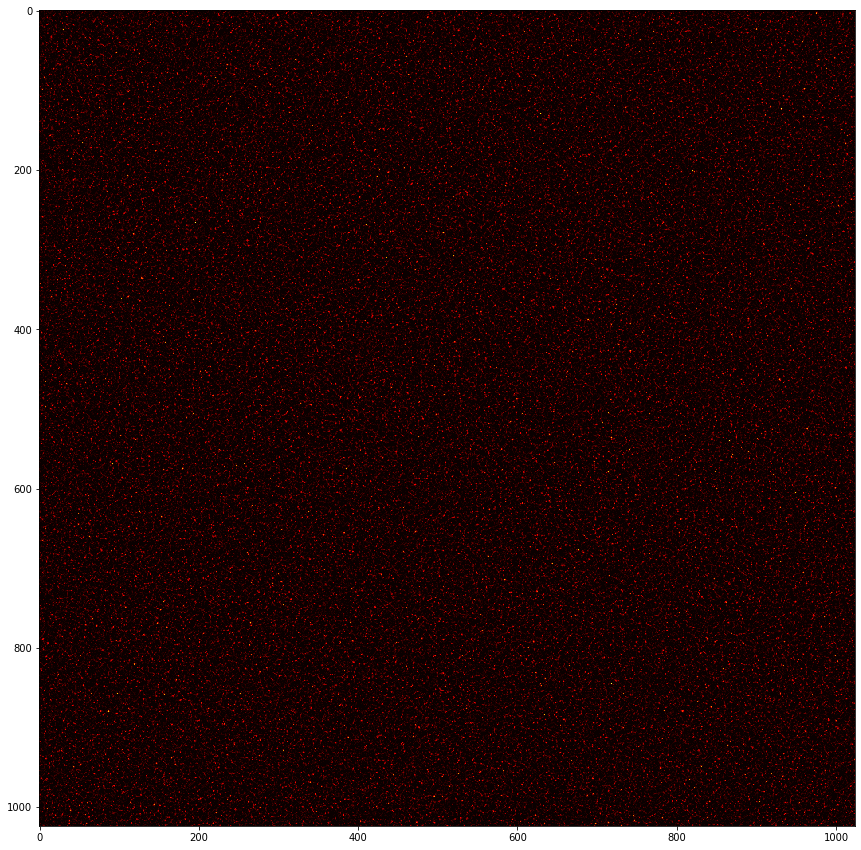

In [2020]:
n = 1024
npart = n**2
dt = 1
m = np.ones(npart)
pos = n*np.random.rand(2,npart)
vel = np.zeros((2,npart))
softening = 0.5
G = 1
Gk = Green_func_fourrier(n,G,softening)

def new_frame(self):
    global n, npart, pos, vel, m, Gk, dt
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,40)
    
fig = plt.figure(figsize=[15,15])
ani = animation.FuncAnimation(fig,new_frame,frames=200,interval=60)
ani.save('nbody_periodic.mp4')

In [2015]:
Video("nbody_periodic.mp4")

## bounded

I will now run the same particles-initially-at-rest scenario for the bounded case but with less particles and a smaller grid (since the code is a lot slower) we get:

In [ ]:
n = 512
npart = n**2
dt = 1
G = 1
softening = 10
m = np.ones(npart)
pos = n*np.random.rand(2,npart)
vel = np.zeros((2,npart))
Gk = Green_func_fourrier(2*n,G,softening)

In [ ]:
nruns = 200
E=[]
for j in range(nruns):
    pot,rho,pos,vel,Ei,npart,m = take_step_bounded(n,npart,pos,vel,m,Gk,dt)
    E.append(Ei)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,40)
    plt.show()
    plt.pause(0.0001)
plt.plot(E)
plt.show()

As we can see, since the particles start out with no velocity, there is no pressure holding them together, and so they rapidly collapse to the center of the box. Once they all merge into the center, the immense gravitational pressure suddently generated shoots many particles outwards in all directions, leaving a dense ball in the moddle, a bit like a supernova.

We can see that energy is not conserved, since it is not in a closed system: both the potential and the particles can leave the box! 

That being said, we can see that during the colapse, since less and less potential escapes the box as the particles contract, the energy initially decreases. Ater the explosion, where a lot of particles leave, it suddently increases as all the fast particles exit the box. This leaves behind a blob of particles in the middle which is mostly a closed system, and thus the energy is mostly conserved beyond that point.

Let's make it into a video, but with even higher resolution!

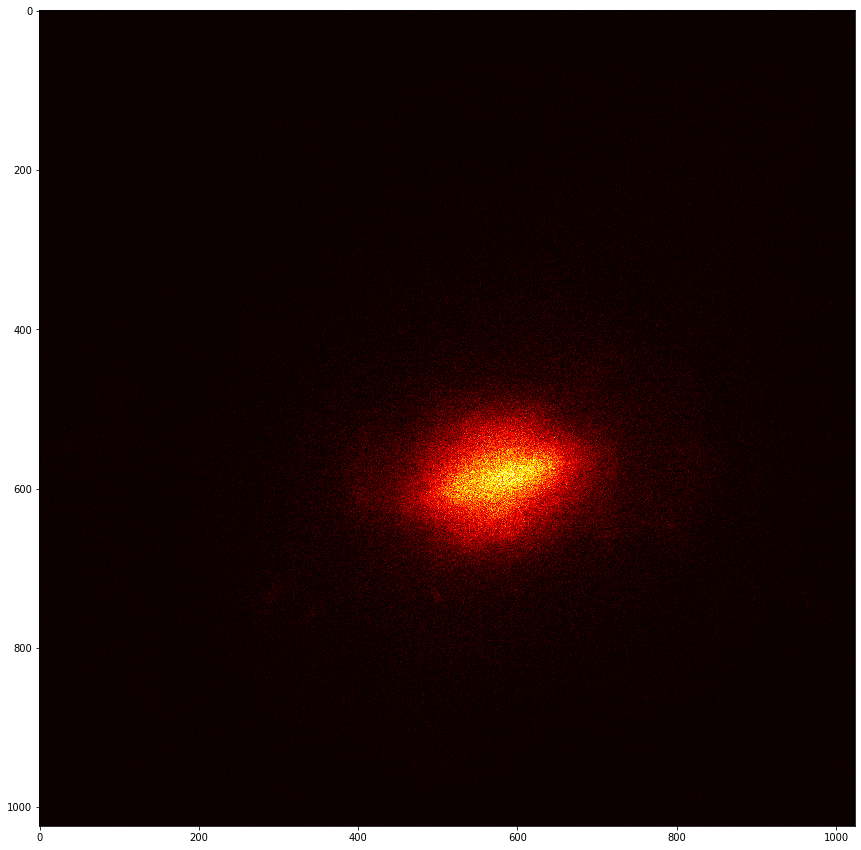

In [2026]:
n = 1024
npart = n**2
dt = 1
G = 1
softening = 10
m = np.ones(npart)
pos = n*np.random.rand(2,npart)
vel = np.zeros((2,npart))
Gk = Green_func_fourrier(2*n,G,softening)

def new_frame(self):
    global n, npart, pos, vel, m, Gk, dt
    pot,rho,pos,vel,E,npart,m = take_step_bounded(n,npart,pos,vel,m,Gk,dt)
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,40)
    
fig = plt.figure(figsize=[15,15])
ani = animation.FuncAnimation(fig,new_frame,frames=200,interval=100)
ani.save('nbody_bounded.mp4')

In [2027]:
Video("nbody_bounded.mp4")

# Part 4

For this part, I will write a routine which generates a mass distribution with noise proportional to $k^{-3}$ from a prior mass dstribution. 

I will use the initial mass distribution to generate a density grid with a 2D histogram, and take its FFT. Each cell in this new 2d fourrier mass array is a "mass mode". I will invert each mass mode, cube it, multiply each it by a random number from -1 to 1 and then scale the new array by some noise factor $a$. I will then add this fourrier noise to the fourrier mass and inverse FFT it.

This gives us a new mass density with $k^{-3}$ noise. To obtain the mass array which this corresponds to, I will take the new masses as the ratio between the new and old mass density grids at each point where there was previously a mass present. This amounts to redistributing the mass into the original mass array such that the mass from particles into the same array are weighted equally. Since any way of distributing the mass into the original array which results in the new density will work, redistributing it equally among particles is valid.

In [ ]:
def noisy_mass(m,pos,a):
    rho = np.histogram2d(pos[0]%n,pos[1]%n,bins=n,range=[[0, n], [0, n]],weights=m)[0]
    rhok = np.fft.rfft2(rho)
    rhoabs3 = 1/rhok**3
    rho_noisy = rhok + a*(2*np.random.rand(n,n//2+1)-1)*rhoabs3
    rho_new = np.fft.fftshift(np.abs(np.fft.irfft2(rho_noisy)))
    m_new = rho_new[pos[0].astype(int),pos[1].astype(int)]/rho[pos[0].astype(int),pos[1].astype(int)]
    return m_new

Now, let's test-run this on a 512x512 array with $2^{18}$ (about 250k) particles, while carefully adjusting the scaling factor such that the noise is neither negligeable, not dominating the data. I found that $a = 5 \times 10^{5}$ to be a good value for our grid.

Also note that each run has different noise, so it will look slightly different, but they should overall be largely the same.

In [2022]:
n = 512
npart = n**2
dt = 1
pos = n*np.random.rand(2,npart)
m = np.ones(npart)
m = noisy_mass(m,pos,5e5)
vel = np.zeros((2,npart))
softening = 0.5
G = 1
Gk = Green_func_fourrier(n,G,softening)

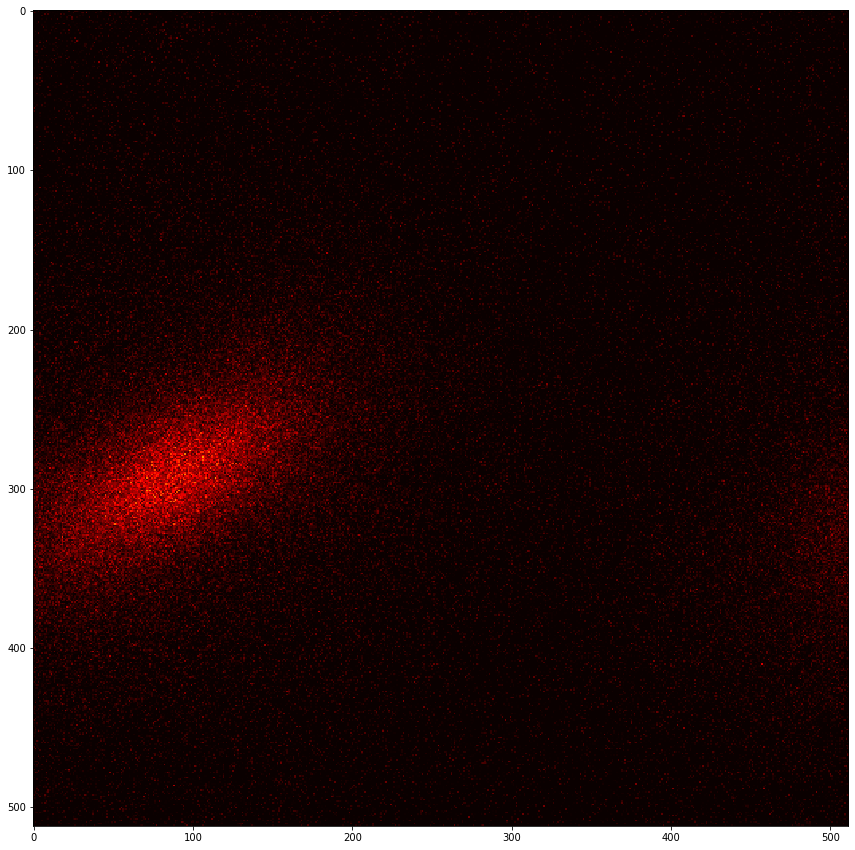

In [2023]:
nruns = 200
for j in range(nruns): 
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,40)
    plt.show()
    plt.pause(0.0001)
plt.show()

As we can see, the mass fluctuations mean they clump up into larger balls and do so faster than in our periodic run, but overall it looks mostly the same.

Now, let's make a video!

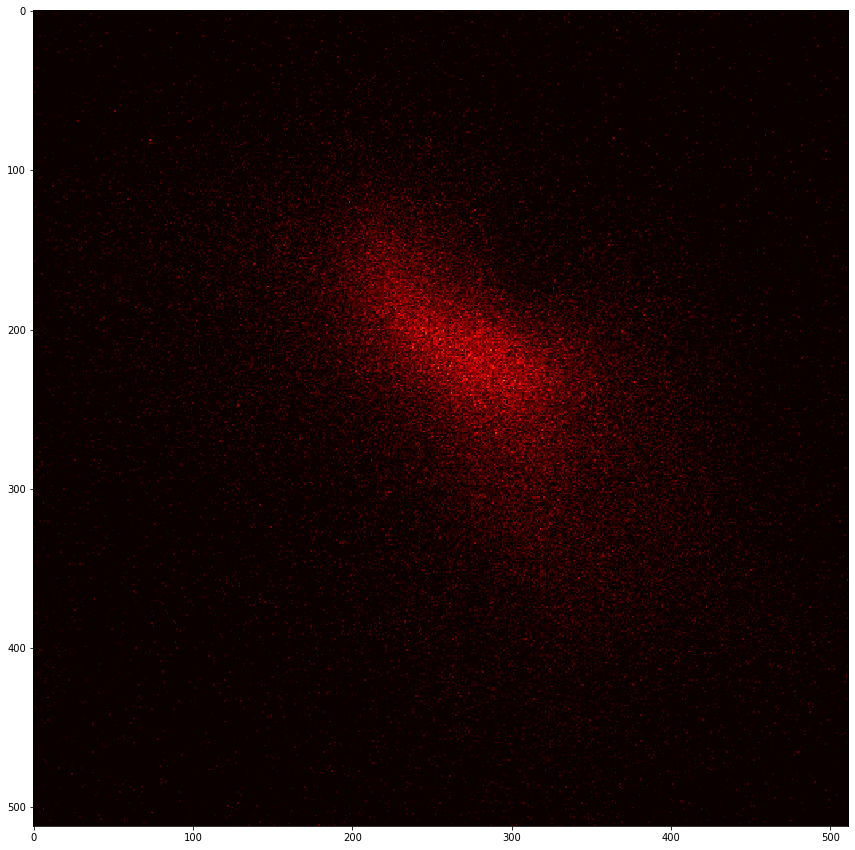

In [2024]:
n = 512
npart = n**2
dt = 1
pos = n*np.random.rand(2,npart)
m = np.ones(npart)
m = noisy_mass(m,pos,5e5)
vel = np.zeros((2,npart))
softening = 0.5
G = 1
Gk = Green_func_fourrier(n,G,softening)

def new_frame(self):
    global n, npart, pos, vel, m, Gk, dt
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,40)
    
fig = plt.figure(figsize=[15,15])
ani = animation.FuncAnimation(fig,new_frame,frames=200,interval=60)
ani.save('nbody_k3_noise.mp4')

In [2025]:
Video("nbody_k3_noise.mp4")

## extra tests
While I was bug-testing the code I ran multiple interesting tests, so I will put them here.

I tried running the code from the periodic part with one of the masses in the middle being much heavier than the rest, analogous a supermassive glack hole in the center of a galaxy. Unsurprisingly, everything crshed into it.

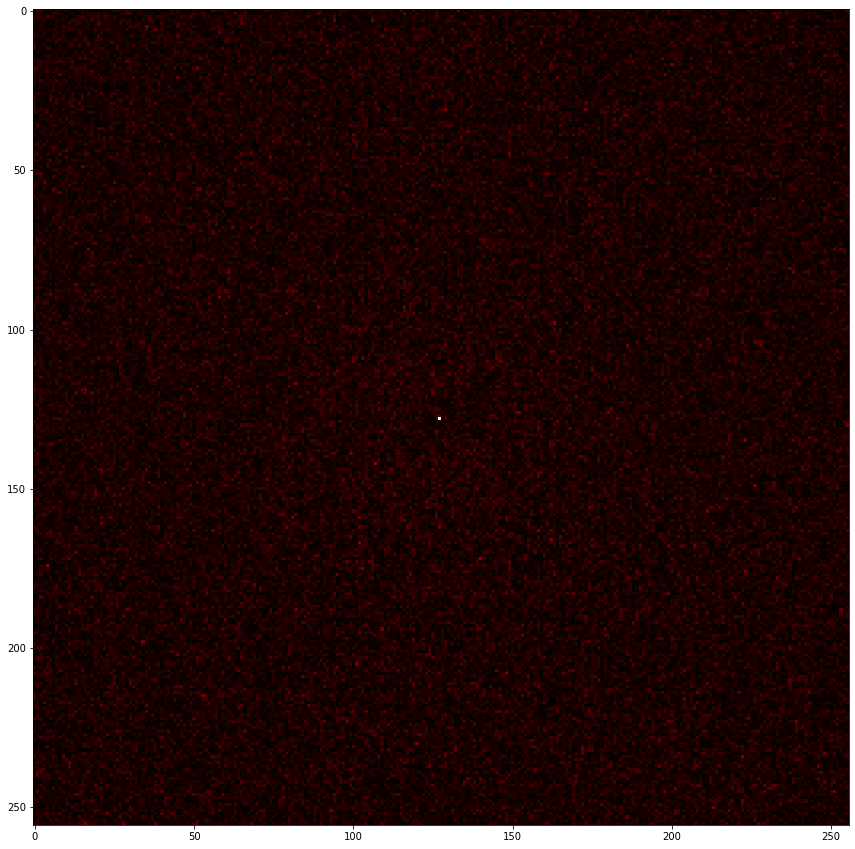

In [2080]:
n = 256
npart = n**2
dt = 1
G = 1
softening = 0.5
Gk = Green_func_fourrier(n,G,softening)

m = np.ones(npart)
m[0]=10000

pos = n*np.random.rand(2,npart)
pos[0,0]=pos[1,0]=n/2

vel = np.zeros((2,npart))
vel[0,0]=vel[1,0]=0

nruns = 200
for j in range(nruns):
    
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,40)
    plt.show()
    plt.pause(0.0001)

Another thing I tried is to have all the particles initially rotate around the center in the bounded case so as to give them a net angular momentum. I then tuned it just right so that they don't rapidly collapse or fling themselves apart, hoping it would form a spiral galaxy. It didn't exactly happen but I feel like it was close.

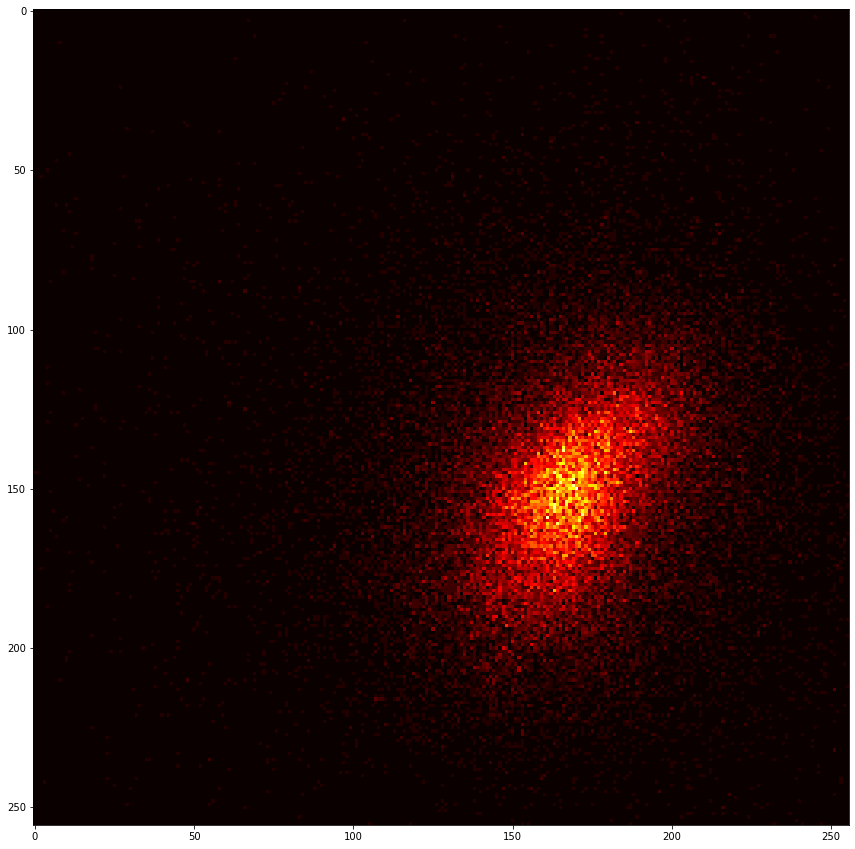

In [2035]:
n = 256
npart = 100000
dt = 1
G = 1
softening = 0.5
Gk = Green_func_fourrier(2*n,G,softening)

m = np.ones(npart)
pos = n*np.random.rand(2,npart)
vel = np.zeros((2,npart))
vel = 0.05*np.array([-pos[1]+n//2,pos[0]-n//2])

nruns = 200
for j in range(nruns):
    pot,rho,pos,vel,E,npart,m = take_step_bounded(n,npart,pos,vel,m,Gk,dt)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.show()
    plt.pause(0.0001)

Combining both previous tests was probably a better bet at forming a spiral galaxy, I think it's really close now! but still not quite it. I probably need to model in Dark Matter to get the real deal, since particles farther away orbit way too slowly to form spiral arms. It is interesting though how the "black hole" cleared the center of any debree.

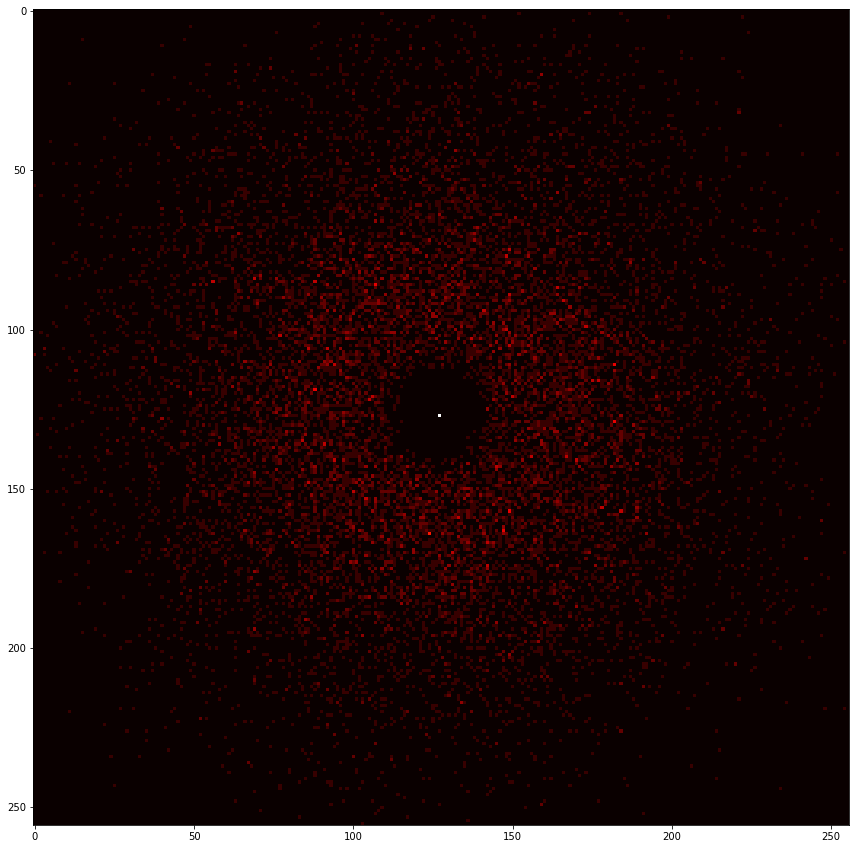

In [2047]:
n = 256
npart = 100000
dt = 1
G = 1
softening = 0.5
Gk = Green_func_fourrier(2*n,G,softening)

m = np.ones(npart)
m[0]=50000
pos = n*np.random.rand(2,npart)
pos[0,0]=pos[1,0]=n/2
vel = np.zeros((2,npart))
vel = 0.1*np.array([-pos[1]+n//2,pos[0]-n//2])

nruns = 200
for j in range(nruns):
    pot,rho,pos,vel,E,npart,m = take_step_bounded(n,npart,pos,vel,m,Gk,dt)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,15)
    plt.show()
    plt.pause(0.0001)

Next I tried to arrange all the particles perfectly in an evenly spaced gird to see if they would eventually collapse due to floating point errors in position. Surprisingly, they did not, nothing happened at all!!

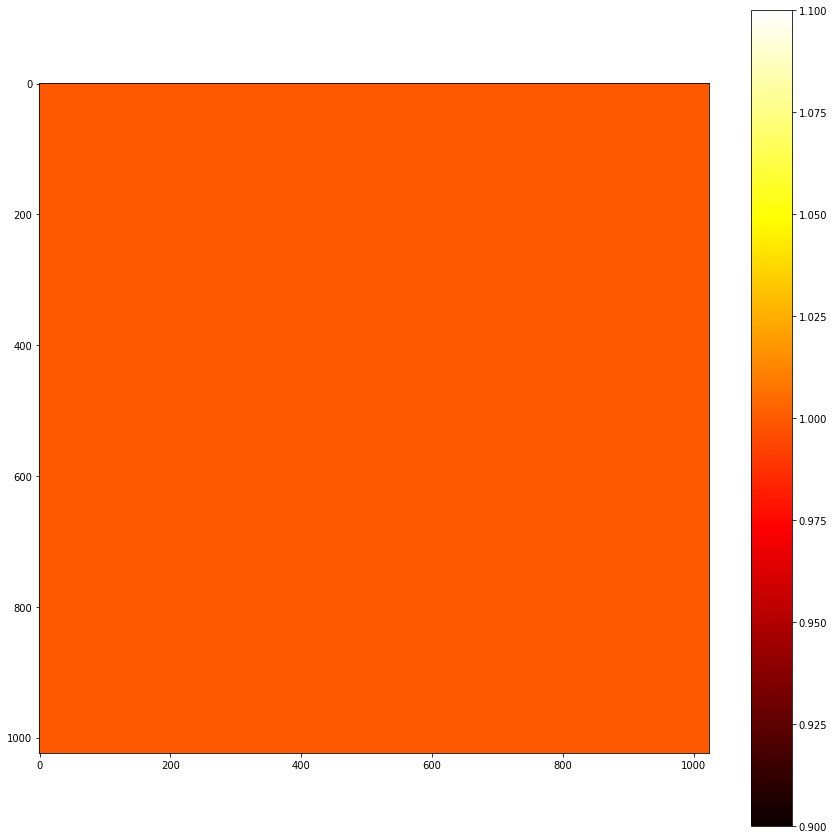

In [2049]:
n = 1024
npart = n**2
dt = 1
softening = 0.5
G = 10
Gk = Green_func_fourrier(n,G,softening)

m = np.ones(npart)
a = np.meshgrid(np.arange(n),np.arange(n))
pos = np.array([a[1].flatten(),a[0].flatten()])
vel = np.zeros((2,npart))

nruns = 100
for j in range(nruns):
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.colorbar()
    plt.show()
    plt.pause(0.0001)

I this tried repeating it but with one of the masses at the center of the grid very slightly heavier than the others by one part in a billion... and it did indeed rapidly collapse!

However, the colapse initially happened in a very strange fractal-looking shape, I have no idea why that is... I tried lowering the timestep to see it evolve more clearly but then I get crashes due to floating point errors in the position. 

I modified the algorithm a little bit to take care of these errors and gave it another go, and I found that the pattern is different for every timestep I pick!

The fractals are thus probably floating point artefacts but they still look neat

In [2090]:
def take_step_periodic_modified(n,npart,pos,vel,m,Gk,dt):
    rho=np.histogram2d(pos[0]%n,pos[1]%n,bins=n,range=[[0, n], [0, n]],weights=m)[0]
    pot = np.fft.fftshift(np.fft.irfft2(np.fft.rfft2(rho)*Gk))
    F = np.gradient(pot)
    pos = pos%n
    vel[0]=vel[0]+dt*F[0][pos[0].astype(int),pos[1].astype(int)]/m
    vel[1]=vel[1]+dt*F[1][pos[0].astype(int),pos[1].astype(int)]/m
    pos=(pos+(vel*dt))%n
    E = np.sum(0.5*(m*(vel[0]**2+vel[1]**2))-0.5*np.sum(pot))
    return pot,rho,pos,vel,E

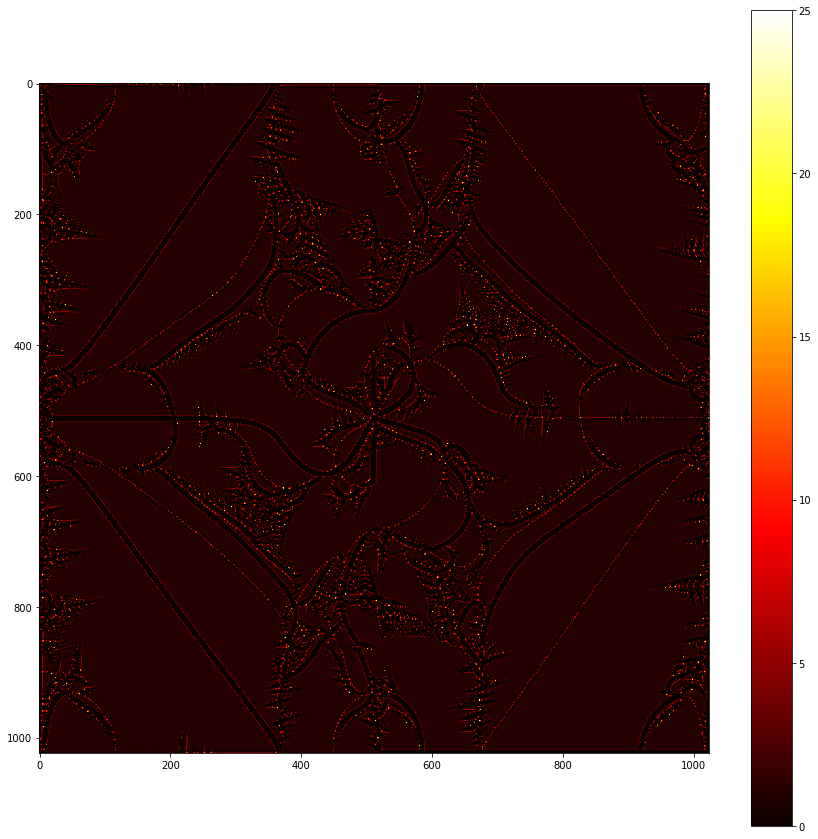

In [2092]:
n = 1024
npart = n**2
dt = 0.05
softening = 0.5
G = 10
Gk = Green_func_fourrier(n,G,softening)

m = np.ones(npart)
m[npart//2+n//2]=1.0000000001
a = np.meshgrid(np.arange(n),np.arange(n))
pos = np.array([a[1].flatten(),a[0].flatten()])
vel = np.zeros((2,npart))


nruns = 50
for j in range(nruns):
    pot,rho,pos,vel,E = take_step_periodic_modified(n,npart,pos,vel,m,Gk,dt)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.colorbar()
    plt.show()
    plt.pause(0.0001)
plt.show()

I also tried increasing the softening on the standard periodic boundary conditions run to see what would happen. Turns out it makes interesting filament-like patterns appear. My guess would be that it is because we are allowing particles to get closer together without flinging each-other away.

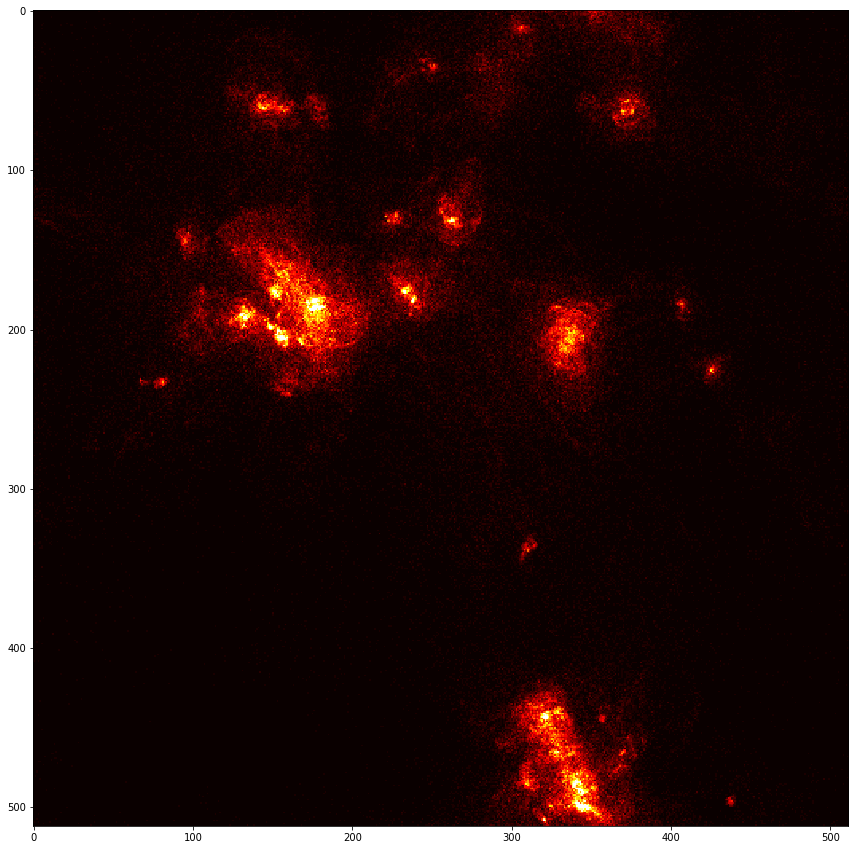

In [2076]:
n = 512
npart = n**2
dt = 1
G = 1
softening = 50
Gk = Green_func_fourrier(n,G,softening)

m = np.ones(npart)
pos = n*np.random.rand(2,npart)
vel = np.zeros((2,npart))

nruns = 100
for j in range(nruns):
    
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.clim(0,40)
    plt.show()
    plt.pause(0.0001)

Finally, I tried staring the particles with a very fast random initial velocity to simulate a high pressure gas. As we would expect, the pressure prevented them from collapsing into a ball like in the other cases, so it remained a diffuse gas.

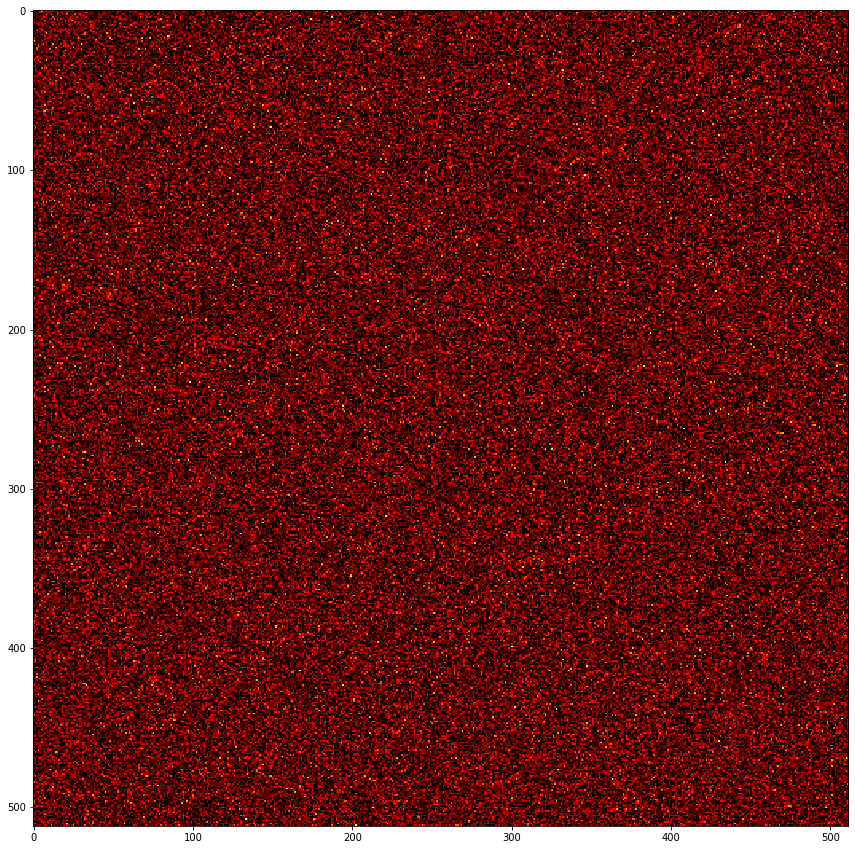

In [2079]:
n = 512
npart = n**2
dt = 0.1
G = 1
softening = 0.5
Gk = Green_func_fourrier(n,G,softening)

m = np.ones(npart)
pos = n*np.random.rand(2,npart)
vel = 100*(np.random.rand(2,npart)-0.5)

nruns = 100
for j in range(nruns):
    pot,rho,pos,vel,E = take_step_periodic(n,npart,pos,vel,m,Gk,dt)
    clear_output(wait = True)
    plt.figure(figsize=[15,15])
    plt.imshow(rho,cmap = plt.cm.hot)
    plt.show()
    plt.pause(0.0001)